In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score

In [92]:
annotated_df = pd.read_csv('../data/softlabels_per_Subtype.csv', sep=',', index_col=0)
rnaseq_df = pd.read_csv('../data/Deconvo2.csv', sep=',', index_col=0).reset_index(names="Case ID")
rnaseq_df['Case ID'] = rnaseq_df['Case ID'].str.split('-').str[:3].str.join('-')
rnaseq_df['Sample ID'] = rnaseq_df['Case ID'].str.split('-').str[:4].str.join('-')

brca_df_filtered = annotated_df[
    (annotated_df['event.BRCA1'] != '1') &
    (annotated_df['event.BRCA2'] != 'Bi-allelic-undetermined') &
    (annotated_df['event.PALB2'] != '2')
]

# Identify common samples across the dataframes
common_samples = set(rnaseq_df['Case ID']).intersection(set(brca_df_filtered.index))

# Filter RNA-seq dataframe for common samples
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]

# Filter BRCA dataframe for common samples
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

rnaseq_df_common.set_index('Case ID', inplace=True)

# Sort the samples in both dataframes by index
rnaseq_df_common = rnaseq_df_common.sort_index()
brca_df_common = brca_df_common.sort_index()


In [93]:
genes_validation = pd.read_csv('../data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

# genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)

In [94]:
# Drop columns that have only zeros
genes_validation_transposed = genes_validation_transposed.loc[:, ~(genes_validation_transposed == 0).all()]

# drop duplicates
genes_validation_transposed_sorted = genes_validation_transposed.loc[:, ~genes_validation_transposed.columns.duplicated()]

In [ ]:
deseq_results=pd.read_csv('../data/basic_deseq_HRD_contrast.csv', index_col=0)
deseq_filtered_rna_seq_df = rnaseq_df_common[rnaseq_df_common.columns.intersection(deseq_results.index)]

# Step 1: Find common columns
common_columns = set(deseq_filtered_rna_seq_df.columns).intersection(genes_validation_transposed.columns)

# Step 2: Filter each dataframe to keep only common columns
deseq_filtered_rna_seq_df_common = deseq_filtered_rna_seq_df[list(common_columns)]
genes_validation_common = genes_validation_transposed_sorted[list(common_columns)]

# Display the resulting shapes to confirm
print("Shape of filtered deseq_filtered_rna_seq_df:", deseq_filtered_rna_seq_df_common.shape)
print("Shape of filtered genes_validation:", genes_validation_common.shape)

breast_filt = genes_validation_common[genes_validation_common.index.str.contains('BREAST')]

Shape of filtered deseq_filtered_rna_seq_df: (857, 6347)
Shape of filtered genes_validation: (1019, 6347)



Training Elastic Net to predict HRD probabilities:


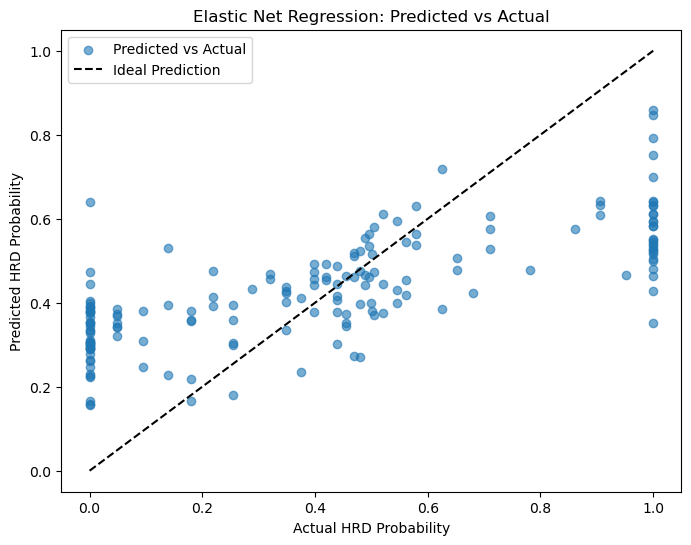


Results for Elastic Net Regression:
Mean Squared Error: 0.075
R^2 Score: 0.409


{'Mean Squared Error': 0.07487995783531638, 'R^2 Score': 0.40858246469984894}

In [125]:
# Data Preprocessing Function
def preprocess_data(X, y, task='regression'):
    """
    Preprocesses data by splitting into train-test sets and scaling features.
    For regression, no label encoding is applied.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Elastic Net Training & Evaluation
def train_evaluate_elastic_net_regression(X_train, X_test, y_train, y_test):
    """
    Trains and evaluates an Elastic Net model for regression.
    Returns the trained model and evaluation metrics.
    """
    model = ElasticNet(alpha=0.25, l1_ratio=0.3, max_iter=1000, random_state=42)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Scatter plot of predictions vs actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
    plt.plot([0, 1], [0, 1], 'k--', label='Ideal Prediction')
    plt.xlabel('Actual HRD Probability')
    plt.ylabel('Predicted HRD Probability')
    plt.title('Elastic Net Regression: Predicted vs Actual')
    plt.legend(loc="upper left")
    plt.show()
    
    # Collect evaluation metrics
    metrics = {
        'Mean Squared Error': mse,
        'R^2 Score': r2
    }
    
    return model, metrics

# Main Execution
def main():
    """
    Main function for preprocessing data, training Elastic Net for regression, and displaying results.
    """
    print("\nTraining Elastic Net to predict HRD probabilities:")
    
    X_train, X_test, y_train, y_test = preprocess_data(
        rnaseq_df_common.drop(columns=["Sample ID"]), brca_df_common['soft prob'], task='regression'
        # deseq_filtered_rna_seq_df_common, brca_df_common['soft prob'], task='regression'
    )
    
    model, metrics = train_evaluate_elastic_net_regression(X_train, X_test, y_train, y_test)
    
    print("\nResults for Elastic Net Regression:")
    print(f"Mean Squared Error: {metrics['Mean Squared Error']:.3f}")
    print(f"R^2 Score: {metrics['R^2 Score']:.3f}")
    
    return model, metrics

# Execute Main
elastic_net_model, elastic_net_metrics = main()
elastic_net_metrics


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
X_train, X_test, y_train, y_test = preprocess_data(
    deseq_filtered_rna_seq_df_common, brca_df_common['soft prob'], task='regression'
)
# Define parameter grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
}

# Initialize ElasticNet model
elastic_net = ElasticNet(max_iter=1000, random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best parameters and model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

# Evaluate on test data
y_pred = best_model.predict(X_test)
print("Test R^2 Score:", r2_score(y_test, y_pred))


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 6.769e-03
  model = cd_fast.enet_coordinate_descent(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 6.958e-03
  model = cd_fast.enet_coordinate_descent(
/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.7}
Best R^2 Score: 0.5697026882447995
Test R^2 Score: 0.6287508258566237


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.404e-02, tolerance: 8.601e-03
  model = cd_fast.enet_coordinate_descent(


In [106]:
# Align breast_filt with deseq_filtered_rna_seq_df_common columns
breast_filt_aligned = breast_filt.reindex(columns=deseq_filtered_rna_seq_df_common.columns, fill_value=0)

# Check for column alignment
print("Are columns aligned?", list(breast_filt_aligned.columns) == list(deseq_filtered_rna_seq_df_common.columns))

# Use breast_filt_aligned for predictions
predictions = elastic_net_model.predict(breast_filt_aligned)
breast_filt['predictions'] = predictions.clip(0, 1)  # Clip predictions to [0, 1]


Are columns aligned? True


/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but ElasticNet was fitted without feature names



In [107]:
predictions

array([ 898.2153817 , 1155.3497302 ,  152.98440355, -220.30633851,
       1198.83781593,  487.95507626, 1019.85617736,  387.50521696,
       1122.63337295, -138.9386092 ,  493.79577836,  639.13295743,
        -89.08022139,  884.07554483,  529.60920396,  658.99871964,
        458.29165979,  172.66402733,  -87.74418686, 1358.31804969,
       1351.48993932,  679.89033672,  916.25540836,  696.42071075,
        233.79274452,  846.20935584, -623.40695425, 1239.7119549 ,
        873.12753559,  325.92399864,  470.02542521, -142.69331689,
        309.13911571,  994.20280111,  234.69115368,  116.08937055,
       -479.07262161, 1161.93024041, -478.90752143,  404.87841447,
        172.70014103,   28.81231857,  569.73402913,  154.96801802,
        612.02864895, 1069.81009842, -105.44650486, -151.66083487,
        803.04851008,   84.69010196, -280.84800334])

In [108]:
predictions = elastic_net_model.predict(breast_filt)
# Display or save the predictions
print(predictions)

# Optionally, add predictions as a new column to the DataFrame
breast_filt['predictions'] = predictions

/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but ElasticNet was fitted without feature names



ValueError: X has 6348 features, but ElasticNet is expecting 6347 features as input.

In [109]:
breast_filt.index = breast_filt.index.str.split('_').str[0]

In [110]:
breast_filt

Description,ATP6V1E2,GPATCH2,MCM5,TMEM14B,BTF3L4,FIS1,FBXO38,SEPHS2,LPAR6,IQCK,...,MYC,HDAC4,FOS,FNDC1,TMEM218,ARHGEF19,CELF1,TOB1,GPX8,predictions
AU565,524.0,3150.0,14056.0,13095.0,6772.0,15719.0,5450.0,21687.0,3.0,541.0,...,22768.0,975.0,1039.0,10.0,1748.0,1491.0,24739.0,20495.0,151.0,1.0
BT20,2410.0,4704.0,26442.0,10358.0,8569.0,5736.0,5247.0,13938.0,67.0,572.0,...,12176.0,5896.0,48170.0,1.0,6.0,4954.0,25338.0,11434.0,2101.0,1.0
BT474,591.0,4025.0,12649.0,6145.0,12108.0,9023.0,26.0,21971.0,487.0,694.0,...,10665.0,2253.0,2380.0,5.0,570.0,1713.0,22367.0,34359.0,1863.0,1.0
BT483,502.0,5445.0,5239.0,5118.0,9910.0,11674.0,5646.0,19688.0,625.0,1591.0,...,6278.0,2521.0,11117.0,14.0,2270.0,2756.0,21670.0,40560.0,1224.0,0.0
BT549,446.0,2731.0,21457.0,21824.0,13766.0,8825.0,7712.0,16051.0,2712.0,1032.0,...,20089.0,3015.0,7555.0,1441.0,2913.0,2341.0,31009.0,3222.0,24607.0,1.0
CAL120,670.0,5993.0,7944.0,19486.0,11919.0,6981.0,6869.0,18931.0,14.0,433.0,...,30671.0,2512.0,27218.0,10.0,3308.0,1277.0,20786.0,4909.0,11353.0,1.0
CAL148,4466.0,6070.0,19001.0,11718.0,17993.0,21197.0,5047.0,35393.0,512.0,2529.0,...,40614.0,6888.0,29610.0,22.0,4408.0,18360.0,36105.0,33729.0,78.0,1.0
CAL51,1214.0,3157.0,18561.0,6434.0,10433.0,5600.0,5323.0,8169.0,14.0,1872.0,...,3204.0,3813.0,9649.0,38.0,2352.0,1320.0,22175.0,5137.0,12156.0,1.0
CAL851,784.0,2108.0,14131.0,20867.0,8227.0,8801.0,3638.0,9616.0,18.0,1336.0,...,13395.0,1173.0,3640.0,28.0,1744.0,1224.0,10567.0,7426.0,4270.0,1.0
CAMA1,557.0,4686.0,25181.0,8227.0,12763.0,14448.0,12372.0,27655.0,1081.0,1464.0,...,19190.0,3388.0,45327.0,16.0,1065.0,6040.0,20077.0,31486.0,315.0,0.0


In [111]:
# drug_resp = pd.read_csv('../data/validation/BRCA_IC_Sat Jan 11 20_40_55 2025.csv')
drug_resp = pd.read_csv('../data/validation/BRCA_IC_Sat Jan 18 23_56_13 2025.csv')

parps = ['Olaparib', 'Talazoparib', 'Niraparib', 'Rucaparib', 'Veliparib']
parpi_resp = drug_resp[drug_resp['Drug Name'].isin(parps)]
parpi_resp_filt = parpi_resp[['Drug Name', 'Cell Line Name', 'IC50']]
parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])
test = parpi_resp_filt[parpi_resp_filt['Drug Name'] == 'Olaparib']

/Users/danirahman/miniforge3/envs/hrdclass/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log10

/var/folders/zc/6j26nlgs3xz5s7v6pjz2b22r0000gn/T/ipykernel_67253/2804555619.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [112]:
test['Cell Line Name'] = test['Cell Line Name'].str.replace('-', '', regex=False)

/var/folders/zc/6j26nlgs3xz5s7v6pjz2b22r0000gn/T/ipykernel_67253/2008896216.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [113]:
import plotly_express as px

In [114]:
from scipy.stats import ttest_ind
import plotly_express as px
stats = {}
for drug in parpi_resp['Drug Name'].unique():
    #print(drug)
    d = parpi_resp_filt[parpi_resp_filt['Drug Name'] == drug]
    merged = d.merge(breast_filt.reset_index(), left_on='Cell Line Name', right_on='index')

    merged = merged.sort_values(by='Cell Line Name')

    group_0 = merged.loc[merged['predictions'] == 0, 'log10IC50']
    group_1 = merged.loc[merged['predictions'] == 1, 'log10IC50']


    t_stat, p_value = ttest_ind(group_0, group_1, equal_var = False)
    stats[drug] = p_value    
stats

{'Olaparib': 0.15707796434878527,
 'Veliparib': 0.5730922813143458,
 'Rucaparib': 0.38187669767531884,
 'Niraparib': 0.8632271460811698,
 'Talazoparib': 0.3251331251132518}

In [115]:
merged = parpi_resp_filt.merge(breast_filt.reset_index(), left_on='Cell Line Name', right_on='index')
px.box(merged, x = 'Drug Name', y = 'log10IC50', color = 'predictions')

In [40]:
from scipy.stats import ttest_ind
import plotly_express as px
stats = {}
for drug in parpi_resp['Drug Name'].unique():
    #print(drug)
    d = parpi_resp_filt[parpi_resp_filt['Drug Name'] == drug]
    merged = d.merge(breast_filt.reset_index(), left_on='Cell Line Name', right_on='index')

    merged = merged.sort_values(by='Cell Line Name')

    group_0 = merged.loc[merged['predictions'] == 0, 'log10IC50']
    group_1 = merged.loc[merged['predictions'] == 1, 'log10IC50']


    t_stat, p_value = ttest_ind(group_0, group_1, equal_var = False)
    stats[drug] = p_value    
stats

/var/folders/zc/6j26nlgs3xz5s7v6pjz2b22r0000gn/T/ipykernel_60874/3410912523.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = ttest_ind(group_0, group_1, equal_var = False)
/var/folders/zc/6j26nlgs3xz5s7v6pjz2b22r0000gn/T/ipykernel_60874/3410912523.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = ttest_ind(group_0, group_1, equal_var = False)
/var/folders/zc/6j26nlgs3xz5s7v6pjz2b22r0000gn/T/ipykernel_60874/3410912523.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = ttest_ind(group_0, group_1, equal_var = False)
/var/folders/zc/6j26nlgs3xz5s7v6pjz2b22r0000gn/T/ipykernel_60874/3410912523.py:15: SmallSampleWarning: One or more sam

{'Olaparib': nan,
 'Veliparib': nan,
 'Rucaparib': nan,
 'Niraparib': nan,
 'Talazoparib': nan}

In [41]:
merged = parpi_resp_filt.merge(breast_filt.reset_index(), left_on='Cell Line Name', right_on='index')
px.box(merged, x = 'Drug Name', y = 'log10IC50', color = 'predictions')

In [42]:
from scipy.stats import spearmanr
import plotly_express as px

stats = {}

for drug in parpi_resp['Drug Name'].unique():
    # Filter data for the specific drug
    d = parpi_resp_filt[parpi_resp_filt['Drug Name'] == drug]
    merged = d.merge(breast_filt.reset_index(), left_on='Cell Line Name', right_on='index')

    # Calculate correlation between HRD probability and log10IC50
    corr, p_value = spearmanr(merged['predictions'], merged['log10IC50'])
    stats[drug] = {'Spearman Correlation': corr, 'P-value': p_value}

# Display statistics
print(stats)

# Merge data for visualization
merged = parpi_resp_filt.merge(breast_filt.reset_index(), left_on='Cell Line Name', right_on='index')

# Scatter plot of HRD probability vs. log10IC50
scatter_plot = px.scatter(
    merged,
    x='predictions',
    y='log10IC50',
    color='Drug Name',
    title='HRD Probability vs. log10IC50 for PARPi Response',
    labels={'predictions': 'HRD Probability', 'log10IC50': 'log10(IC50)'},
    trendline="ols"  # Optional: Adds a linear trendline
)
scatter_plot.show()

# Optional: Box plot with probability bins
merged['HRD Probability Bin'] = pd.cut(
    merged['predictions'],
    bins=[0, 0.33, 0.66, 1],
    labels=['Low (0-0.33)', 'Medium (0.33-0.66)', 'High (0.66-1)']
)

box_plot = px.box(
    merged,
    x='HRD Probability Bin',
    y='log10IC50',
    color='Drug Name',
    title='log10IC50 by HRD Probability Bins',
    labels={'HRD Probability Bin': 'HRD Probability (Binned)', 'log10IC50': 'log10(IC50)'}
)
box_plot.show()


{'Olaparib': {'Spearman Correlation': 0.27450980392156865, 'P-value': 0.28629837865879204}, 'Veliparib': {'Spearman Correlation': 0.07598039215686275, 'P-value': 0.7719448512425434}, 'Rucaparib': {'Spearman Correlation': 0.13235294117647062, 'P-value': 0.6125925983674196}, 'Niraparib': {'Spearman Correlation': 0.45, 'P-value': 0.08029573654339643}, 'Talazoparib': {'Spearman Correlation': -0.029411764705882353, 'P-value': 0.9107803991169198}}
